___

In [1]:
# Import libraries to be used

# Warning messages display
# import warnings
# warnings.filterwarnings(action='once') # https://docs.python.org/3/library/warnings.html#the-warnings-filter

# Directories/Files management
import os.path
## from zipfile import ZipFile # De momento no ha hecho falta 

# Timing
import time

# Data analysis and wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Show all columns in DataFrames
pd.set_option('display.max_rows', 100) # If too high, it greatly slows down the output display and freezes the kernel


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot') # choose a style: 'plt.style.available'
sns.set_theme(context='notebook',
              style="darkgrid") # {darkgrid, whitegrid, dark, white, ticks}
palette = sns.color_palette("flare", as_cmap=True);
import altair as alt

# Machine Learning
## from sklearn.[...] import ...

In [2]:
%load_ext memory_profiler

In [3]:
t0 = time.perf_counter() 

In [4]:
# Detect Operating System running and manage paths accordingly

if os.name == 'nt': # Windows
    root = r"C:\Users\turge\CompartidoVM\0.TFM"
    print("Running on Windows.")
elif os.name == 'posix': # Ubuntu
    root = "/home/dsc/shared/0.TFM"
    print("Running on Ubuntu.")
print("root path\t", root)

Running on Windows.
root path	 C:\Users\turge\CompartidoVM\0.TFM


___

In [5]:
cols = [
     'MONTH',
     'DAY_OF_MONTH',
     'DAY_OF_WEEK',
     'OP_UNIQUE_CARRIER',
     'TAIL_NUM',
     'ORIGIN_CITY_MARKET_ID',
     'ORIGIN',
     'DEST_CITY_MARKET_ID',
     'DEST',
     'CRS_DEP_TIME',
     'DEP_TIME',
     'TAXI_OUT_median',
     'TAXI_IN_median',
#      'DEP_DELAY',
#      'DEP_DEL15',
#      'DEP_DELAY_GROUP',
#      'TAXI_OUT',
#      'TAXI_IN',
     'CRS_ARR_TIME',
#      'ARR_TIME',
#      'ARR_DELAY',
     'ARR_DEL15',
#      'ARR_DELAY_GROUP',
#      'CANCELLED',
     'CRS_ELAPSED_TIME',
     'DISTANCE',
     'DISTANCE_GROUP',
     'CARRIER_DELAY',
     'WEATHER_DELAY',
     'NAS_DELAY',
     'SECURITY_DELAY',
     'LATE_AIRCRAFT_DELAY',
]

In [6]:
preprocessed_input_csv_path = os.path.join(root,
                                           "Output_Data",
                                           "US_DoT",
                                           "AL_OTP_MVP_Preprocessed_19_v2_clean.csv")
preprocessed_input_csv_path

'C:\\Users\\turge\\CompartidoVM\\0.TFM\\Output_Data\\US_DoT\\AL_OTP_MVP_Preprocessed_19_v2_clean.csv'

In [7]:
%%time

df_all = pd.read_csv(preprocessed_input_csv_path,
                 encoding='latin1',
#                  nrows=1e4,
                 usecols=cols, # This way, the extra column is disregarded for the loading process
                 low_memory = False)

Wall time: 27 s


In [8]:
df_all.shape

(7268232, 23)

In [14]:
sample_length = int(1e4)
delayed = df_all[df_all['ARR_DEL15'] == 1].sample(sample_length // 2)
not_delayed = df_all[df_all['ARR_DEL15'] == 0].sample(sample_length // 2)
df = delayed.append(not_delayed)

df_validation = df_all.loc[set(df_all.index) - set(df.index), :]

df.shape, df_validation.shape

((10000, 23), (7258232, 23))

### Feature analysis

[Dealing with categorical features with high cardinality: Target Encoding](https://medium.com/@kr.vishwesh54/dealing-with-categorical-features-with-high-cardinality-target-encoding-baa9298bf257)

In [15]:
X = df.drop('ARR_DEL15', axis=1)
X.sample(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TAXI_OUT_median,TAXI_IN_median
469826,1,3,4,AA,N925AN,33570,SAN,31703,JFK,750,753.0,1608,318.0,2446.0,10,3.0,0.0,32.0,0.0,0.0,19.0,10.0
6797575,12,13,5,UA,N458UA,31453,IAH,30325,DEN,1300,1306.0,1427,147.0,862.0,4,6.0,0.0,25.0,0.0,0.0,18.0,8.0
1986397,4,8,1,UA,N769UA,32575,LAX,31453,IAH,55,329.0,557,182.0,1379.0,6,0.0,0.0,3.0,0.0,154.0,18.0,7.0
6321088,11,7,4,F9,N719FR,30647,CLE,30466,PHX,604,734.0,836,272.0,1737.0,7,90.0,0.0,3.0,0.0,0.0,13.0,7.0
6929902,12,29,7,WN,N7719A,30529,BDL,32467,FLL,500,500.0,820,200.0,1173.0,5,0.0,0.0,0.0,0.0,0.0,9.0,7.0


In [16]:
y = df['ARR_DEL15']
y.sample(5)

3648963    1.0
4678802    1.0
7050305    0.0
6037644    1.0
2220959    1.0
Name: ARR_DEL15, dtype: float64

In [17]:
def val_freq(col='', df=df):
    i = 0
    for v in df[col].value_counts().sort_index():
        print("{} : {} records ({:.2f}%)" \
              .format(df[col].value_counts().sort_index().index[i], v,  v / len(df) * 100))
        i += 1

In [18]:
%%time

for col in df.columns:
    print(col, ':', df[col].nunique(), 'unique values')
    if df[col].nunique() < 50:
        val_freq(col)
    print("")

MONTH : 12 unique values
1 : 792 records (7.92%)
2 : 766 records (7.66%)
3 : 829 records (8.29%)
4 : 853 records (8.53%)
5 : 864 records (8.64%)
6 : 921 records (9.21%)
7 : 925 records (9.25%)
8 : 879 records (8.79%)
9 : 739 records (7.39%)
10 : 849 records (8.49%)
11 : 709 records (7.09%)
12 : 874 records (8.74%)

DAY_OF_MONTH : 31 unique values
1 : 327 records (3.27%)
2 : 331 records (3.31%)
3 : 308 records (3.08%)
4 : 314 records (3.14%)
5 : 299 records (2.99%)
6 : 295 records (2.95%)
7 : 342 records (3.42%)
8 : 327 records (3.27%)
9 : 306 records (3.06%)
10 : 319 records (3.19%)
11 : 365 records (3.65%)
12 : 325 records (3.25%)
13 : 367 records (3.67%)
14 : 327 records (3.27%)
15 : 336 records (3.36%)
16 : 327 records (3.27%)
17 : 313 records (3.13%)
18 : 336 records (3.36%)
19 : 326 records (3.26%)
20 : 343 records (3.43%)
21 : 359 records (3.59%)
22 : 346 records (3.46%)
23 : 337 records (3.37%)
24 : 282 records (2.82%)
25 : 334 records (3.34%)
26 : 291 records (2.91%)
27 : 335 r

Conclusiones:
- En junio se concentra el mayor número de retrasos. Curiosamente, hay notablemente más vuelos en mayo, julio, agosto y octubre.
- Los D, L, X y J se concentra el mayor número de retrasos (especialmente X). D y X es cuando más vuelos hay con diferencia.

___

In [20]:
%memit

peak memory: 3589.72 MiB, increment: 0.21 MiB


### A Simple Guide to Scikit-learn Pipelines

#### Transformers

Before building the pipeline, let's split the data into a train and test set so that the performance of the model can be validated.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

1. The first step in building the pipeline is to define each transformer type.

In [22]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Wall time: 162 ms


2. Next, let's use the ColumnTransformer to apply the transformations to the correct columns in the dataframe. Before building this, the numeric and categorical columns shall be listed.

In [23]:
%%time

numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['ARR_DEL15'], axis=1).columns
categorical_features = df.select_dtypes(include=['object']).columns
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

Wall time: 17 ms


#### Fitting the classifier

The next step is to create a pipeline that combines the preprocessor created above with a classifier. In this case a simple RandomForestClassifier has been used to start with.

In [24]:
%%time

from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=0))])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Wall time: 4.45 s


#### Model selection

**A pipeline can also be used during the model selection process**. The following example code loops through a number of scikit-learn classifiers applying the transformations and training the model.

In [25]:
%%time

from sklearn.metrics import accuracy_score, log_loss, f1_score, fbeta_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))    
    # TEST !!!     
    predictions = pipe.predict(X_test)
    print(fbeta_score(y_test, predictions, beta=2), f1_score(y_test, predictions), recall_score(y_test, predictions), precision_score(y_test, predictions), accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions), "\n")   

KNeighborsClassifier(n_neighbors=3)
model score: 0.697
0.625 0.6625835189309577 0.6022267206477733 0.7363861386138614 0.697
[[799 213]
 [393 595]] 

SVC(C=0.025, probability=True, random_state=0)
model score: 0.803
0.6946236559139786 0.7663107947805456 0.6538461538461539 0.9255014326647565 0.803
[[960  52]
 [342 646]] 

DecisionTreeClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0 1.0
[[1012    0]
 [   0  988]] 

RandomForestClassifier(random_state=0)
model score: 0.999
0.9983799108950991 0.9989868287740628 0.9979757085020243 1.0 0.999
[[1012    0]
 [   2  986]] 

AdaBoostClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0 1.0
[[1012    0]
 [   0  988]] 

GradientBoostingClassifier(random_state=0)
model score: 1.000
1.0 1.0 1.0 1.0 1.0
[[1012    0]
 [   0  988]] 

Wall time: 46.3 s


**The pipeline can also be used in grid search** to find the best performing parameters. To do this, let's first create a parameter grid for the chosen model.

*One important thing to note is that there is a need to append the name given to the classifier part of the pipeline to each parameter name. In the code above its name is ‘classifier’ so 'classifier__' has been added to each parameter.*

Next a grid search object has been created, which includes the original pipeline. When fit is called, the transformations are applied to the data, before a cross-validated grid-search is performed over the parameter grid.

In [26]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [27]:
%%time

param_grid = { 
    'classifier__n_estimators': [200, 500],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy']}

from sklearn.model_selection import GridSearchCV

scoring = {'AUC': 'roc_auc', 'F1': 'f1', 'Precision': 'precision',
           'Recall': 'recall', 'Accuracy': 'accuracy'}

CV = GridSearchCV(rf, param_grid, n_jobs= 1, scoring=scoring, refit='F1')
# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``

CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)
CVscores = pd.DataFrame(CV.cv_results_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'auto', 'classifier__n_estimators': 500}
0.9465046573447063
Wall time: 6min 59s


In [28]:
CVscores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_test_Precision,split1_test_Precision,split2_test_Precision,split3_test_Precision,split4_test_Precision,mean_test_Precision,std_test_Precision,rank_test_Precision,split0_test_Recall,split1_test_Recall,split2_test_Recall,split3_test_Recall,split4_test_Recall,mean_test_Recall,std_test_Recall,rank_test_Recall,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
0,0.642004,0.021440,0.141113,0.002710,gini,4,auto,200,"{'classifier__criterion': 'gini', 'classifier_...",0.986001,0.978519,0.971115,0.990119,0.988328,0.982816,0.007060,37,0.928524,0.904054,0.903623,0.925753,0.930851,0.918561,0.012129,42,1.000000,0.986726,1.000000,1.000000,0.998573,0.997060,0.005197,35,0.866584,0.834165,0.824190,0.861768,0.871731,0.851687,0.018913,49,0.933125,0.911250,0.911875,0.930625,0.935000,0.924375,0.010555,38
1,1.484060,0.047302,0.296817,0.003031,gini,4,auto,500,"{'classifier__criterion': 'gini', 'classifier_...",0.985925,0.992420,0.991777,0.991264,0.997383,0.991754,0.003643,25,0.936340,0.935889,0.922767,0.935719,0.952381,0.936619,0.009399,23,1.000000,0.995781,1.000000,1.000000,1.000000,0.999156,0.001688,23,0.880299,0.882793,0.856608,0.879203,0.909091,0.881599,0.016668,33,0.940000,0.939375,0.928125,0.939375,0.954375,0.940250,0.008344,23
2,0.632010,0.010124,0.143510,0.005347,gini,4,sqrt,200,"{'classifier__criterion': 'gini', 'classifier_...",0.986001,0.978519,0.971115,0.990119,0.988328,0.982816,0.007060,37,0.928524,0.904054,0.903623,0.925753,0.930851,0.918561,0.012129,42,1.000000,0.986726,1.000000,1.000000,0.998573,0.997060,0.005197,35,0.866584,0.834165,0.824190,0.861768,0.871731,0.851687,0.018913,49,0.933125,0.911250,0.911875,0.930625,0.935000,0.924375,0.010555,38
3,1.436512,0.016220,0.299215,0.003320,gini,4,sqrt,500,"{'classifier__criterion': 'gini', 'classifier_...",0.985925,0.992420,0.991777,0.991264,0.997383,0.991754,0.003643,25,0.936340,0.935889,0.922767,0.935719,0.952381,0.936619,0.009399,23,1.000000,0.995781,1.000000,1.000000,1.000000,0.999156,0.001688,23,0.880299,0.882793,0.856608,0.879203,0.909091,0.881599,0.016668,33,0.940000,0.939375,0.928125,0.939375,0.954375,0.940250,0.008344,23
4,0.554304,0.007026,0.139913,0.004425,gini,4,log2,200,"{'classifier__criterion': 'gini', 'classifier_...",0.988251,0.891746,0.820532,0.941191,0.985712,0.925487,0.063193,60,0.945170,0.830812,0.722128,0.861670,0.929186,0.857793,0.079849,60,0.991781,0.926380,0.661140,0.843675,0.991525,0.882900,0.123500,60,0.902743,0.753117,0.795511,0.880448,0.874222,0.841208,0.057034,56,0.947500,0.846250,0.693125,0.858125,0.933125,0.855625,0.090496,60
5,1.273214,0.014287,0.335192,0.084821,gini,4,log2,500,"{'classifier__criterion': 'gini', 'classifier_...",0.993166,0.938545,0.927973,0.980148,0.993070,0.966580,0.027818,49,0.940092,0.870926,0.858736,0.933504,0.961340,0.912920,0.040512,50,0.995816,0.912568,0.853448,0.959264,0.995995,0.943418,0.054419,49,0.890274,0.832918,0.864090,0.909091,0.929016,0.885078,0.033750,25,0.943125,0.876250,0.857500,0.935000,0.962500,0.914875,0.040632,50
6,0.659393,0.006043,0.144110,0.003122,gini,5,auto,200,"{'classifier__criterion': 'gini', 'classifier_...",0.990227,0.983953,0.980247,0.990515,0.990937,0.987176,0.004313,33,0.939153,0.911409,0.914015,0.925033,0.931652,0.924253,0.010461,35,1.000000,0.986919,1.000000,1.000000,0.997159,0.996816,0.005069,39,0.885287,0.846633,0.841646,0.860523,0.874222,0.861662,0.016393,45,0.942500,0.917500,0.920625,0.930000,0.935625,0.929250,0.009265,35
7,1.600810,0.085273,0.314406,0.015046,gini,5,auto,500,"

In [29]:
predictions = CV.predict(X_test)
probabilities = CV.predict_proba(X_test)

(0.8953053593685085, 0.9318918918918919, 0.8724696356275303, 1.0, 0.937)

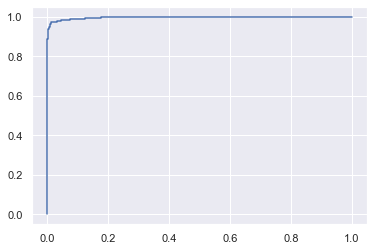

In [30]:
from sklearn.metrics import fbeta_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score

tpr, fpr, thresolds = roc_curve(y_test, probabilities[:, 1])
plt.plot(tpr, fpr)
print(fbeta_score(y_test, predictions, beta=2), f1_score(y_test, predictions), recall_score(y_test, predictions), precision_score(y_test, predictions), accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

### Validation

In [32]:
X_validation = df_validation.drop('ARR_DEL15', axis=1)
X_validation.sample(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,TAXI_OUT_median,TAXI_IN_median
713341,2,6,3,NK,N527NK,31453,IAH,30977,ORD,2000,1958.0,2234,154.0,925.0,4,0.0,0.0,0.0,0.0,0.0,13.0,13.0
842233,2,10,7,AA,N744P,30852,DCA,33195,TPA,1200,1152.0,1432,152.0,814.0,4,0.0,0.0,0.0,0.0,0.0,18.0,4.0
843015,2,20,3,AA,N537UW,30325,DEN,30466,PHX,1500,1513.0,1659,119.0,602.0,3,11.0,0.0,4.0,0.0,2.0,15.0,6.0
1652128,3,28,4,UA,N37267,30325,DEN,33195,TPA,751,744.0,1314,203.0,1506.0,7,0.0,0.0,0.0,0.0,0.0,16.0,5.0
5290497,9,30,1,WN,N8307K,30466,PHX,31453,HOU,905,906.0,1345,160.0,1020.0,5,0.0,0.0,0.0,0.0,0.0,10.0,5.0


In [33]:
y_validation = df_validation['ARR_DEL15']
y_validation.sample(5)

2733467    0.0
650427     0.0
4935282    0.0
6696522    0.0
4678719    0.0
Name: ARR_DEL15, dtype: float64

In [34]:
predictions = CV.predict(X_validation)
probabilities = CV.predict_proba(X_validation)

0.9032789553508674 0.9371876548412564 0.8820042289957111 0.9997371519720153 0.977452222524714
[[5873658     321]
 [ 163336 1220917]]


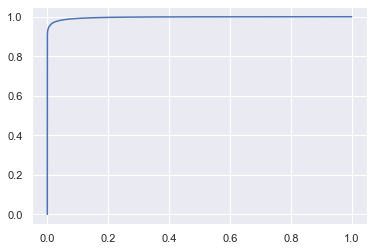

In [35]:
from sklearn.metrics import fbeta_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score

tpr, fpr, thresolds = roc_curve(y_validation, probabilities[:, 1])
plt.plot(tpr, fpr)
print(fbeta_score(y_validation, predictions, beta=2), f1_score(y_validation, predictions), recall_score(y_validation, predictions), precision_score(y_validation, predictions), accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))

# Hacer aquí la confusion plot matrix !!

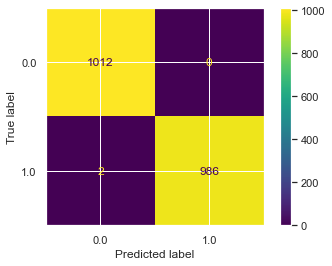

In [37]:
plot_confusion_matrix(rf, X_test, y_test) 

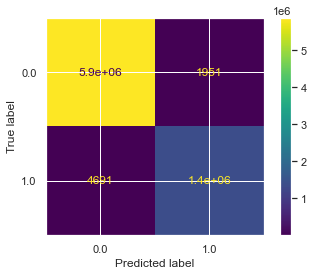

In [38]:
plot_confusion_matrix(rf, X_validation, y_validation) 

___

In [36]:
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)

Time elapsed:  2270.9865345000003


___

### [Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

- Binary classification (only):
    - [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve): Compute precision-recall pairs for different probability thresholds.
        - The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The **precision** is intuitively the ability of the classifier **not to label as positive a sample that is negative**.
        - The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The **recall** is intuitively the ability of the classifier to **find all the positive samples**.

    ### RECALL could be a potentially strong metric for this case; "from all the flights classified as delayed, the actual (true) number delyed flights is as high as possible."

    - [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve): A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.
        
- Multi-class classification (or binary):
    - [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix): Compute confusion matrix to evaluate the accuracy of a classification.
    ![IMG_Confusion_Matrix](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_0011.png)
    - [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score): Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

- Multi-label classification (or binary or multi-class):
    - [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): Accuracy classification score.
        - It is the ratio of number of correct predictions to the total number of input samples.
        - **It works well only if there are equal number of samples belonging to each class.**
    - [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report): Build a text report showing the main classification metrics.
    - [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score): Compute the F1 score, also known as balanced F-score or F-measure.
        - The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal: `F1 = 2 * (precision * recall) / (precision + recall)`
    - [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
    - [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

### Which metric should be used then?
##### Bear in mind that it's a clear case of imbalanced data

Nomenclature:
- Delayed = Positive
- On-time = Negative 

Considering this:
- False positive (Type I error) → Wrongly classifying an On-time flight as a Delayed flight → Not significantly relevant
- **False negative (Type II error) → Wrongly classifying a Delayed flight as an On-time flight → Highly relevant**

**F-beta** score (\$ F_\beta \$):
![F-beta score](https://wikimedia.org/api/rest_v1/media/math/render/svg/136f45612c08805f4254f63d2f2524bc25075fff)

Two commonly used values for β are:
- **2 : weighs recall higher than precision**
- 0.5 : weighs recall lower than precision.


<em>Probably most people in the industry would accept that an **OTP of 80%* or above is pretty good***. That’s 4 in 5 flights arriving within 15 minutes of their scheduled arrival time. The very best airlines and airports succeed in punctuality closer to 90% - but they remain the exception rather than the rule.</em>  
(Source: [OAG](https://www.oag.com/on-time-performance-airlines-airports))

The actual data from the 7268232 records comprising the OTP dataset accurately confirm this hypothesis:
```
Delays: 5878979 (80.89%)
On-time: 1389253 (19.11%)
```

In some rare cases, the calculation of Precision or Recall can cause a division by 0. Regarding the precision, this can happen if there are no results inside the answer of an annotator and, thus, the true as well as the false positives are 0. For these special cases, we have defined that **if the true positives, false positives and false negatives are all 0, the precision, recall and F1-measure are 1**. This might occur in cases in which the gold standard contains a document without any annotations and the annotator (correctly) returns no annotations. **If true positives are 0 and one of the two other counters is larger than 0, the precision, recall and F1-measure are 0.**

[A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/)  
**Imbalanced classifications** pose a challenge for predictive modeling as **most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class**. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore **the problem is more sensitive to classification errors for the minority class than the majority class**.

[Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)  
1. Try Changing Your Performance Metric:
    - Confusion Matrix
    - Precision: 
    - Recall: 
    - F1 Score
    - Kappa
    - ROC Curves
2. Try Resampling Your Dataset:
    - You can add copies of instances from the under-represented class called **over-sampling** (or more formally **sampling with replacement**) → when you don’t have a lot of data (tens of thousands of records or less)
    - You can delete instances from the over-represented class, called **under-sampling** → when you have an a lot data (tens- or hundreds of thousands of instances or more)
3. Try Different Algorithms:
    - That being said, **decision trees often perform well on imbalanced datasets**. The splitting rules that look at the class variable used in the creation of the trees, can force both classes to be addressed.  
    If in doubt, try a few popular decision tree algorithms like C4.5, C5.0, CART, and Random Forest.

[Guide to Classification on Imbalanced Datasets](https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23)  
There are two main types of techniques to handle imbalanced datasets:
- ### Sampling methods:
    - #### Oversampling
        - How do we generate these samples? The most common way is to generate points that are close in dataspace proximity to existing samples or are ‘between’ two samples, as illustrated below
        - There are some downsides to adding false data points:
            - **Overfitting** risk
            - In addition, adding these values randomly can also contribute **additional noise to our model**
        - Techniques:
            - **SMOTE** (Synthetic minority oversampling technique) → SMOTE generates new samples in between existing data points based on their local density and their borders with the other class. Algorithm:
                - Find its k-nearest minority neighbours
                – Randomly select j of these neighbours
                – Randomly generate synthetic samples along the lines joining the minority sample and its j selected neighbours (j depends on the amount of oversampling desired)
    - #### Undersampling
        - Is undersampling a good idea? Undersampling is recommended by many statistical researchers but is **only good if enough data points are available on the undersampled class**
        - Is undersampling a good idea? Undersampling is recommended by many statistical researchers but is only good if enough data points are available on the undersampled class
- ### Cost-sensitive methods
    - #### Upweighting
    Upweighting is analogous to over-sampling and works by increasing the weight of one of the classes keeping the weight of the other class at one
    - #### Down-weighting
    Down-weighting is analogous to under-sampling and works by decreasing the weight of one of the classes keeping the weight of the other class at one

```python
# Example of how to implement cost-sensitive learning:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
model.fit(X_train, y_train, class_weight=class_weights)
```

- Benefits of cost-sensitive learning:
    - It is much simpler to implement
    - Easier to communicate to individuals

### Assessment Metrics
- #### F1-score
    - What does a high F1 score mean? It suggests that both the precision and recall have high values — this is good and is what you would hope to see upon generating a well-functioning classification model on an imbalanced dataset. A low value indicates that either precision or recall is low, and maybe a call for concern
    - Good F1 scores are generally lower than good accuracies (in many situations, an **F1 score of 0.5 would be considered pretty good**)

- #### Receiver Operating Characteristic (ROC) Curve
   - Depending on your application, you may be very averse to false positives as they may be very costly (e.g. launches of nuclear missiles) and thus **would like a classifier that has a very low false-positive rate**.

- #### Area Under Curve (AUC)
   - If a particular classifier has an ROC of 0.6 and another has an ROC of 0.8, the latter is clearly a better classifier. The AUC has the benefit that it is independent of the decision criteria — the classification threshold — and thus makes it easier to compare these classifiers.